In [4]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random # Generate pseudo-random numbers
from random import randint
from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split # Split arrays or matrices into random train and test subsets
from sklearn.metrics import classification_report, confusion_matrix
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import arabic_reshaper # Reconstruct Arabic sentences to be used in applications that don't support Arabic
from bidi.algorithm import get_display
from PIL import Image

import warnings 
warnings.filterwarnings("ignore")

In [6]:
Language = "Ar"
ImageClassMapping_path = "Labels/ImagesClassPath.csv"
ClassLabels_path = "Labels/ClassLabels.xlsx"
ImagesRoot_path = "C:/Users/abdel/Arabic Sign Language/"
ModelFileName ='Model_255.h5'

In [7]:
df_ImageClassPath = pd.read_csv(ImageClassMapping_path)
display(df_ImageClassPath.head())

,id,ClassId,ImagePath
0,1,0,ArASL_Database_54K/ain/AIN (1).JPG
1,2,0,ArASL_Database_54K/ain/AIN (10).JPG
2,3,0,ArASL_Database_54K/ain/AIN (100).jpg
3,4,0,ArASL_Database_54K/ain/AIN (1000).JPG
4,5,0,ArASL_Database_54K/ain/AIN (1001).JPG


In [65]:
# load Class Labels
df_Classes = pd.read_excel(ClassLabels_path,index_col=0)
display(df_Classes.head())

,Class,ClassAr
ClassId,,
0,ain,عين
1,al,ال
2,aleff,الف
3,bb,باء
4,dal,دال


In [5]:
df_ImageClassPath.groupby("ClassId").size().describe()

count      32.000000
mean     1689.031250
std       187.343825
min      1293.000000
25%      1589.500000
50%      1713.500000
75%      1797.250000
max      2114.000000
dtype: float64

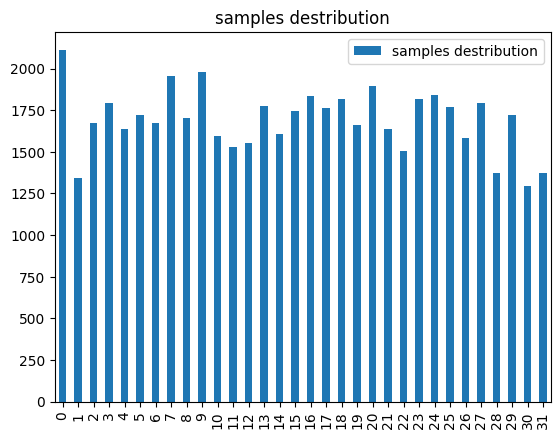

In [6]:
ddata = {"samples destribution":df_ImageClassPath.groupby("ClassId").size()}
iindex = range(32)

ddataframe = pd.DataFrame(data=ddata, index= iindex)
ddataframe.plot.bar(stacked= True, rot=90, title='samples destribution')
plt.show(block= True)

In [7]:
# Split 54K Images into 3 groups of Fixed Prediction, training and test
# the dataset is 32 class,split is maintaind as per class 
def SplitData(predictions,testsize):
    
    min = df_ImageClassPath.groupby("ClassId").size().min()
    print('{0} Samples per Class'.format(min))
    
    # empty dataframes with same column difinition
    df_TrainingSet = df_ImageClassPath[0:0].copy()
    df_TestSet = df_ImageClassPath[0:0].copy()
    df_PredSet = df_ImageClassPath[0:0].copy()

    # Create the sets by loop thru classes and append
    for index,row in df_Classes.iterrows():
        # make sure all class are same size 
        df_FullSet = df_ImageClassPath[df_ImageClassPath['ClassId'] == row['ClassId']].sample(min,random_state= 42)
        
#         df_FullSet = df_ImageClassPath[df_ImageClassPath['ClassId'] == row['ClassId']]
        
        df_PredSet = df_PredSet.append(df_FullSet.sample(n=predictions, random_state=1))
        df_FullSet = pd.merge(df_FullSet,df_PredSet, indicator=True, 
                              how='left').query('_merge=="left_only"').drop('_merge', axis=1)
        
        trainingSet, testSet = train_test_split(df_FullSet, test_size= testsize)        
        
        df_TrainingSet = df_TrainingSet.append(trainingSet)
        df_TestSet = df_TestSet.append(testSet)
    
    return df_TrainingSet,df_TestSet,df_PredSet

In [9]:
# prepare Images, and class Arrays
def getDataSet(setType,isDL): # 'Training' for Training dataset , 'Testing' for Testing data set
    imgs = []
    lbls = []
    df = pd.DataFrame(None)
    
    if setType =='Training':
        df = dtTraining.copy()
    elif setType=='Test':
        df = dtTest.copy()
    elif setType=='Prediction':
        df = dtPred.copy()

    for index,row in df.iterrows():
        lbls.append(row['ClassId'])
        try:
            imageFilePath = os.path.join(ImagesRoot_path, row['ImagePath'])
            img = load_img(imageFilePath, target_size=(64,64,1), 
                                 color_mode = "grayscale")
            img = img_to_array(img) # to array
            img = img/255 # Normalize
            if isDL == False:
                img = img.flatten() # for knn_classifier Model
            imgs.append(img)

        except Exception as e:
            print(e)
            
    shuffle(imgs,lbls,random_state=255) #Shuffle the dataset

    imgs = np.array(imgs)
    lbls = np.array(lbls)
    if isDL ==True:
        lbls = to_categorical(lbls) # for keras CNN Model
    return imgs, lbls

In [11]:
# Split our Dataset into Training, Test and Prediction
# take 3 images per class for later prediction (96 images 3 x 32 class category)
# split the remaining into 20% test and 80% Training

dtTraining, dtTest,dtPred = SplitData(3,0.3)

1293 Samples per Class


In [12]:
print('Pred     {} \t # {} per class'.format(dtPred.shape[0], dtPred.shape[0] //32))
print('Training {} \t # {} per class'.format(dtTraining.shape[0], dtTraining.shape[0] //32))
print('Test     {} \t # {} per class'.format(dtTest.shape[0], dtTest.shape[0] //32))
print('---------------')
print('Sum      {}'.format(dtTraining.shape[0] + dtTest.shape[0] + dtPred.shape[0]))

Pred     96 	 # 3 per class
Training 28896 	 # 903 per class
Test     12384 	 # 387 per class
---------------
Sum      41376


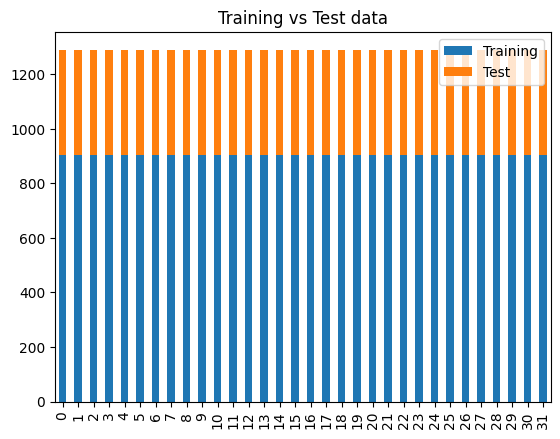

In [13]:
ddata = {"Training":dtTraining.groupby("ClassId").size(),"Test":dtTest.groupby("ClassId").size()}
iindex = range(32)

ddataframe = pd.DataFrame(data=ddata, index= iindex)
ddataframe.plot.bar(stacked= True, rot= 90, title='Training vs Test data')
plt.show(block= True)

In [14]:
X_train,y_train = getDataSet('Training',False)
X_valid,y_valid = getDataSet('Test',False)
X_pred,_ = getDataSet('Prediction',False)
print("Shape of Train Images:{} , Train Labels: {}".format(X_train.shape,y_train.shape))
print("Shape of Test Images:{} , Test Labels: {}".format(X_valid.shape,y_valid.shape))
print("Shape of Prediction Images:{} , Prediction Labels: {}".format(X_pred.shape,"?"))

Shape of Train Images:(28896, 4096) , Train Labels: (28896,)
Shape of Test Images:(12384, 4096) , Test Labels: (12384,)
Shape of Prediction Images:(96, 4096) , Prediction Labels: ?


In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                                      metric_params=None, n_jobs=-1, n_neighbors=5, p=2,weights='uniform')
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [16]:
knnScore = knn_classifier.score(X_train, y_train)
print(knnScore)

0.9499238648947951


In [17]:
y_valid[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
X_valid[0].shape

(4096,)

In [19]:
y_pred=knn_classifier.predict(X_valid)

In [20]:
y_pred[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
import pickle
filename = 'knn_classifier_model.pkl'
pickle.dump(knn_classifier, open(filename, 'wb'))

# test

In [48]:
# load the model from disk

loaded_model = pickle.load(open('knn_classifier_model.pkl', 'rb'))
img = load_img('ArASL_Database_54K/ain/AIN (2).JPG', target_size=(64,64,1), 
                                 color_mode = "grayscale")
img = img_to_array(img) # to array
img = img/255 # Normalize
img = img.flatten()
img.shape
loaded_model.predict([img])[0]

0

In [49]:
Class_name=df_Classes.iloc[loaded_model.predict([img])[0]][1]
Class_name

'عين'

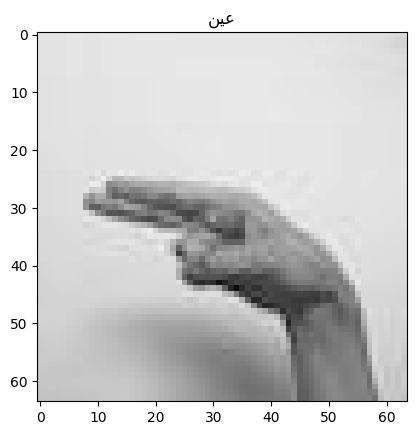

In [50]:
reshaped_text = arabic_reshaper.reshape(Class_name)
artext = get_display(reshaped_text)

fname = 'ArASL_Database_54K/ain/AIN (1).JPG'
image = Image.open(fname).convert("L")
arr = np.asarray(image)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.title(artext)
plt.show()